# Imports

In [15]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

from src.functions.arima_parameters import arima_parameters
from src.utils import init_notebook

In [2]:
init_notebook()

In [25]:
data_folder = "data\processed_data\detrend_data\LinearMADetrend\window-100"
stock_name = "AAPL"

In [26]:
df = pd.read_csv(
    f"{data_folder}/{stock_name}.csv", parse_dates=["Date"], index_col="Date"
)
print(f"{df.shape = }")

df.shape = (756, 6)


# ARIMA

## Predict new price

In [28]:
# Take close price as target variable
price = df["Close"]

In [29]:
# Example: Fit ARMA(1,1) model
model = ARIMA(price, order=arima_parameters)
fitted_arima = model.fit()

# Display model summary
print(fitted_arima.summary())

c:\Users\jules\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-i8ZI35Fj-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jules\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-i8ZI35Fj-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jules\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-i8ZI35Fj-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


c:\Users\jules\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-i8ZI35Fj-py3.10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  756
Model:               ARIMA(10, 0, 10)   Log Likelihood               -1568.804
Date:                Sun, 04 Feb 2024   AIC                           3181.608
Time:                        22:43:06   BIC                           3283.425
Sample:                             0   HQIC                          3220.826
                                - 756                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0508      0.130      0.390      0.697      -0.205       0.307
ar.L1          1.2897      0.234      5.503      0.000       0.830       1.749
ar.L2         -0.5466      0.282     -1.936      0.0

In [30]:
# Make predictions

forecast_steps = 60  # N days to forecast
forecast = fitted_arima.get_forecast(steps=forecast_steps)

date_range = pd.date_range(
    price.index[-1], periods=forecast_steps + 1, freq=price.index.freq
)
forecast_index = date_range[1:]  # Exclude price.index[-1]

predicted_values = forecast.predicted_mean

c:\Users\jules\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-i8ZI35Fj-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\jules\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-i8ZI35Fj-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


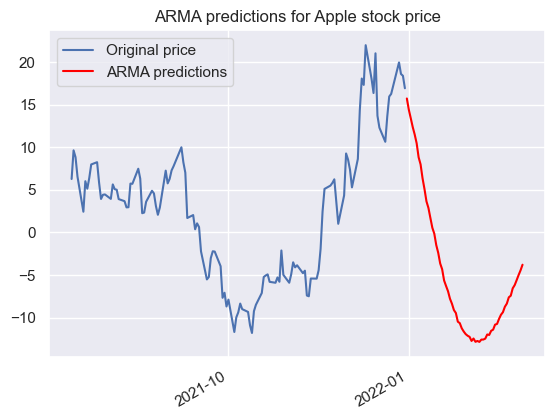

In [31]:
plot_n_days_prior_pred = 2 * forecast_steps

plt.plot(price[-plot_n_days_prior_pred:], label="Original price")
plt.plot(forecast_index, predicted_values, label="ARMA predictions", color="red")
plt.title("ARMA predictions for Apple stock price")
plt.legend()


# Display limited number of date index
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# Rotate x-axis labels
plt.gcf().autofmt_xdate()

plt.show()

## Train test split

In [32]:
train_test_split_date = pd.Timestamp("2021-10-01")
train, test = (
    price[price.index <= train_test_split_date],
    price[price.index > train_test_split_date],
)

In [33]:
model = ARIMA(train, order=arima_parameters)
result = model.fit()

c:\Users\jules\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-i8ZI35Fj-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jules\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-i8ZI35Fj-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jules\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-i8ZI35Fj-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


c:\Users\jules\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-i8ZI35Fj-py3.10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [34]:
forecast_steps = len(test)
forecast = result.get_forecast(steps=forecast_steps)
predicted_values = forecast.predicted_mean

c:\Users\jules\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-i8ZI35Fj-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\jules\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-i8ZI35Fj-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


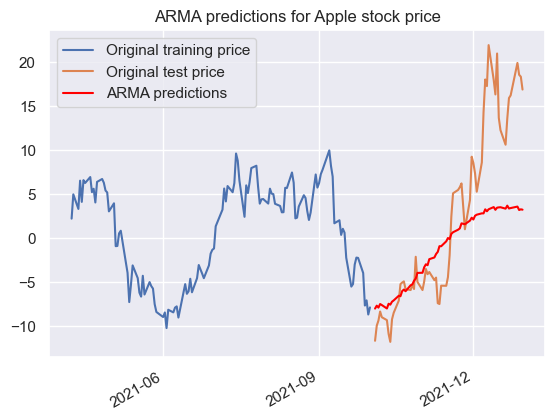

In [35]:
plot_n_days_prior_pred = 2 * forecast_steps

plt.plot(train[-plot_n_days_prior_pred:], label="Original training price")
plt.plot(test, label="Original test price")
plt.plot(test.index, predicted_values, label="ARMA predictions", color="red")
plt.title("ARMA predictions for Apple stock price")
plt.legend()


# Display limited number of date index
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# Rotate x-axis labels
plt.gcf().autofmt_xdate()

plt.show()